In [ ]:
!pip install fiftyone ultralytics diffusers accelerate transformers


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of motor to determine which version is compatible with other requirements. This could take a while.


# FiftyOne dataset

In [ ]:
import cv2
import time
import numpy as np
import pandas as pd

from collections import defaultdict

import matplotlib.pyplot as plt

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
dataset = foz.load_zoo_dataset(
              "open-images-v6",
              split="test",
              label_types="segmentations",
              classes=["Person", "Cat", "Dog", "Car", "Bottle"],
              max_samples=1000,
              only_matching=True
          )

INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v6/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv' to '/root/fiftyone/open-images-v6/test/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/test/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v6/test/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpn84vskfl/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v6/test/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-0.zip' to '/root/fiftyone/open-images-v6/test/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-3.zip' to '/root/fiftyone/open-images-v6/test/labels/masks/3.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-2.zip' to '/root/fiftyone/open-images-v6/test/labels/masks/2.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-1.zip' to '/root/fiftyone/open-images-v6/test/labels/masks/1.zip'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-4.zip' to '/root/fiftyone/open-images-v6/test/labels/masks/4.zip'


INFO:fiftyone.utils.openimages:Downloading 1000 images


 100% |█████████████████| 1000/1000 [2.0m elapsed, 0s remaining, 8.4 files/s]       


INFO:eta.core.utils: 100% |█████████████████| 1000/1000 [2.0m elapsed, 0s remaining, 8.4 files/s]       


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'test'


 100% |███████████████| 1000/1000 [35.2s elapsed, 0s remaining, 18.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [35.2s elapsed, 0s remaining, 18.7 samples/s]      


Dataset 'open-images-v6-test-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-test-1000' created


In [ ]:
# session = fo.launch_app(dataset)

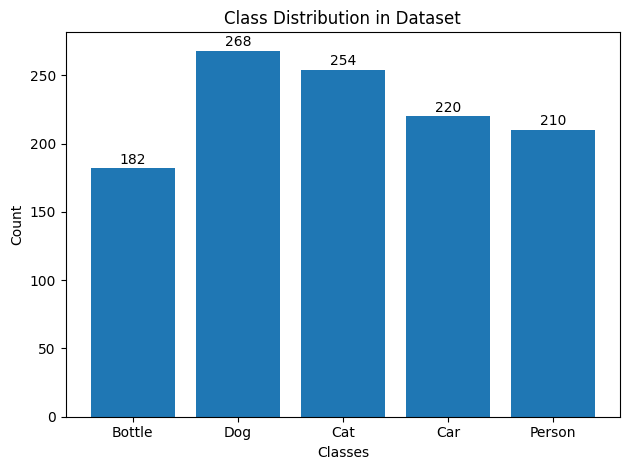

In [ ]:
# Aggregate the distribution of segmentations per class
counts = dataset.count_values("ground_truth.detections.label")

# Extract class names and their corresponding counts
classes = list(counts.keys())
values = list(counts.values())

# Plot a bar chart
bars = plt.bar(classes, values)

# Add numbers on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(value),
             ha="center", va="bottom")


# Add labels and title
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
mask_dataset = dataset.map_labels("ground_truth", {"Person": "person", "Cat": "cat", "Dog": "dog", "Car": "car", "Bottle": "bottle"})
yolo_dataset = dataset.map_labels("ground_truth", {"Person": "person", "Cat": "cat", "Dog": "dog", "Car": "car", "Bottle": "bottle"})

In [ ]:
working_classes = ["person", "cat", "dog", "car", "bottle"]

In [ ]:
def evaluate_model_with_inference_time(dataset, model, pred_key, inference_key):
    for sample in dataset.iter_samples(progress=True):
        img = cv2.imread(sample.filepath)
        # Start timer
        start_time = time.time()

        # Perform inference
        prediction = model.predict(img)

        # End timer
        inference_time = time.time() - start_time

        # Store the result and time
        sample[f"{pred_key}_detections"] = prediction
        sample[inference_key] = inference_time
        sample.save()

# Mask R-CNN

In [ ]:
mrc_model = foz.load_zoo_model("mask-rcnn-resnet50-fpn-coco-torch")

INFO:fiftyone.core.models:Downloading model from 'https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth'...


 100% |██████|    1.3Gb/1.3Gb [4.9s elapsed, 0s remaining, 358.0Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.3Gb/1.3Gb [4.9s elapsed, 0s remaining, 358.0Mb/s]      
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 164MB/s]


In [ ]:
evaluate_model_with_inference_time(mask_dataset, mrc_model, "mask_rcnn", "mask_rcnn_time")

 100% |███████████████| 1000/1000 [4.8m elapsed, 0s remaining, 3.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [4.8m elapsed, 0s remaining, 3.8 samples/s]      


In [ ]:
mask_results = mask_dataset.evaluate_detections(
    "mask_rcnn_detections",
    gt_field="ground_truth",
    eval_key="eval_mask_rcnn",
    use_masks=True,
    method="open-images",
    iou=0.75
)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


  14% |██|------------|  139/1000 [38.1s elapsed, 3.9m remaining, 3.9 samples/s]    

Failed to convert polygon for object '673f581c16643f0323c83cbc' to Shapely format
  15% |██|------------|  153/1000 [42.9s elapsed, 4.4m remaining, 2.1 samples/s]    

Failed to convert polygon for object '673f5c0416643f0323c85492' to Shapely format
 100% |███████████████| 1000/1000 [4.3m elapsed, 0s remaining, 2.8 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [4.3m elapsed, 0s remaining, 2.8 samples/s]       


In [ ]:
mask_results.plot_confusion_matrix(working_classes, include_missing=False)

/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1581: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



In [ ]:
mask_results.print_report(classes=working_classes)

              precision    recall  f1-score   support

      person       0.02      0.60      0.04       210
         cat       0.34      0.84      0.49       254
         dog       0.24      0.85      0.37       268
         car       0.05      0.82      0.10       220
      bottle       0.15      0.84      0.26       182

   micro avg       0.07      0.79      0.13      1134
   macro avg       0.16      0.79      0.25      1134
weighted avg       0.17      0.79      0.26      1134



In [ ]:
# Print some statistics about the total TP/FP/FN counts
print("TP: %d" % mask_dataset.sum("eval_mask_rcnn_tp"))
print("FP: %d" % mask_dataset.sum("eval_mask_rcnn_fp"))
print("FN: %d" % mask_dataset.sum("eval_mask_rcnn_fn"))

TP: 899
FP: 24124
FN: 235


# Yolo

In [ ]:
yolo_model = foz.load_zoo_model("yolov9c-seg-coco-torch")

In [ ]:
evaluate_model_with_inference_time(yolo_dataset, yolo_model, "yolo", "yolo_time")

 100% |███████████████| 1000/1000 [2.5m elapsed, 0s remaining, 8.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [2.5m elapsed, 0s remaining, 8.2 samples/s]      


In [ ]:
yolo_results = yolo_dataset.evaluate_detections(
    "yolo_detections",
    gt_field="ground_truth",
    eval_key="eval_yolo",
    use_masks=True,
    method="open-images",
    iou=0.75
)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


  14% |██|------------|  138/1000 [17.2s elapsed, 1.8m remaining, 9.3 samples/s]    

Failed to convert polygon for object '673f581c16643f0323c83cbc' to Shapely format
  54% |████████-------|  538/1000 [1.1m elapsed, 1.3m remaining, 5.1 samples/s]     

Failed to convert polygon for object '673f639916643f0323c914fb' to Shapely format
 100% |███████████████| 1000/1000 [2.1m elapsed, 0s remaining, 9.3 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [2.1m elapsed, 0s remaining, 9.3 samples/s]       


In [ ]:
yolo_results.plot_confusion_matrix(working_classes, include_missing=False)

/usr/local/lib/python3.10/dist-packages/fiftyone/core/plots/plotly.py:1581: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



In [ ]:
yolo_results.print_report(classes=working_classes)

              precision    recall  f1-score   support

      person       0.06      0.53      0.11       210
         cat       0.92      0.88      0.90       254
         dog       0.64      0.90      0.75       268
         car       0.18      0.72      0.28       220
      bottle       0.47      0.74      0.57       182

   micro avg       0.24      0.77      0.37      1134
   macro avg       0.45      0.75      0.52      1134
weighted avg       0.48      0.77      0.55      1134



In [ ]:
# Print some statistics about the total TP/FP/FN counts
print("TP: %d" % yolo_dataset.sum("eval_yolo_tp"))
print("FP: %d" % yolo_dataset.sum("eval_yolo_fp"))
print("FN: %d" % yolo_dataset.sum("eval_yolo_fn"))

TP: 868
FP: 3827
FN: 266


# Time analysis

In [ ]:
time_data = [(i.mask_rcnn_time, i.yolo_time) for i in dataset.iter_samples()]

In [ ]:
time_df = pd.DataFrame(time_data, columns=["mask-rcnn", "yolo"])
time_df.head()

,mask-rcnn,yolo
0,2.482524,1.089102
1,0.203060,0.115352
2,0.139333,0.122311
3,0.153335,0.115829
4,0.246910,0.064385


<Axes: >

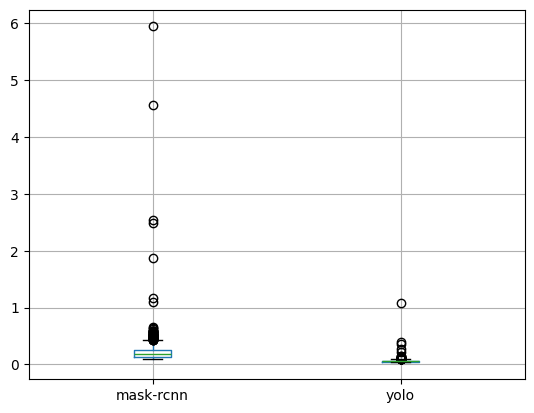

In [ ]:
time_df.boxplot()

In [ ]:
time_df.describe()

,mask-rcnn,yolo
count,1000.000000,1000.000000
mean,0.232871,0.060991
std,0.277942,0.038684
min,0.097496,0.035049
25%,0.139627,0.049995
50%,0.180223,0.055934
75%,0.255121,0.065724
max,5.947419,1.089102


In [ ]:
time_df.to_csv("/content/drive/MyDrive/datasets/time_df.csv", index=False)

# Inpainting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
from PIL import ImageFont, ImageDraw, Image
from ultralytics.engine.results import Masks

In [ ]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
from ultralytics import YOLO

# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c-seg.pt")
model.to(device)

In [ ]:
colors = """
#B52CFF
#348F00
#6B2CFF
#FFFF2C
#FF3535
#FF7A00
#0DA3FF
#FFD700
#20C9A5
#E91E63
#D4AC2B
#8CFF00
#FF007A
#2E91E5
#AFFF3C
#C71585
#FF6F00
#009688
#FFCC00
#4A90E2
#00BCD4
#CDDC39
#FF4081
#795548
#FFC400"""

In [ ]:
colors = [np.array([int(c[i:i+2], 16) for i in (1, 3, 5)]) for c in colors.split("\n") if c]

In [ ]:
import json

with open("coco_classes_eng.json") as f:
    eng_labels = json.load(f)

with open("coco_classes_ukr.json") as f:
    ukr_labels = json.load(f)

In [ ]:
def overlay_masks_on_image(image, results, alpha=0.2, labels=True, location="ukr"):
    fontpath = "./fonts/ttNormPro.ttc"
    font = ImageFont.truetype(fontpath, 14)

    objects = {}
    counters = {}

    for c, mask_obj, box_obj in zip(results[0].boxes.cls.cpu().type(torch.int).numpy(), results[0].masks.xy, results[0].boxes.xyxy):

        # Convert the polygon coordinates to integer
        polygon = np.array(mask_obj, dtype=np.int32)

        # Create a mask for the polygon
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 1)

        class_name = ukr_labels[str(c)] if location == "ukr" else eng_labels[str(c)]

        num = counters.get(class_name, 0)
        if num == 0:
            counters[class_name] = 1
            obj_text = class_name
        else:
            counters[class_name] += 1
            obj_text = f"{class_name} {num}"
        objects[obj_text] = {}
        objects[obj_text]["mask"] = mask
        objects[obj_text]["bbox"] = box_obj


        # Get the color for the current class
        color = colors[c % len(colors)]

        # Create a color mask (with the same shape as the image)
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = color

        # Overlay the mask on the image using the transparency factor
        image = cv2.addWeighted(image, 1, color_mask, alpha, 0)

        # Draw the polygon outline on the image
        image = cv2.polylines(image, [polygon], isClosed=True, color=color.tolist(), thickness=2, lineType=cv2.LINE_AA)

        if labels == True:
            # Find the centroid of the mask to place the label
            moments = cv2.moments(mask)
            if moments["m00"] != 0:
                cX = int(moments["m10"] / moments["m00"])
                cY = int(moments["m01"] / moments["m00"])
                position = (cX, cY)

                # Put the text on the image
                img_pil = Image.fromarray(image)
                draw = ImageDraw.Draw(img_pil)

                bbox = draw.textbbox(position, obj_text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                centered_position = (position[0] - text_width // 2, position[1] - text_height // 2)

                x1, y1, x2, y2 = draw.textbbox(centered_position, obj_text, font=font)
                draw.rounded_rectangle((x1-5, y1-5, x2+5, y2+5), fill=(250,	246, 245), radius=8)

                draw.text(centered_position, obj_text, font=font, fill=(0, 0, 0, 255))
                image = np.array(img_pil)

    return image, objects # BINARY masks and bounding boxes

In [ ]:
def read_and_overlay(img_path):
    image = cv2.imread(img_path)
    # Get the dimensions of the image
    height, width, _ = image.shape

    results = model(image)

    output_image, objects = overlay_masks_on_image(image, results)

    plt.figure(figsize=(width / 50, height / 50))
    # Display the image
    plt.imshow(output_image[..., ::-1])
    plt.axis('off')  # Hide the axis
    plt.show()

    return image, objects


In [ ]:
def inpaint(image, objects, selected_list):
    selected = [objects[i] for i in selected_list]
    # Merge the selected masks into one
    merged_mask = np.zeros_like(selected[0]["mask"], dtype=np.uint8)
    for obj in selected:
        merged_mask = cv2.bitwise_or(merged_mask, obj["mask"])

    init_image = Image.fromarray(image[..., ::-1]).resize((512, 512))

    # Define the kernel size (you can adjust the size for more or less padding)
    kernel_size = 10
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Dilate the mask
    padded_mask = cv2.dilate(merged_mask, kernel, iterations=5)

    mask_image = Image.fromarray(padded_mask * 255).convert('RGB').resize((512, 512))

    prompt = "blend with the background"
    output = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, guidance_scale=20, padding_mask_crop=1).images[0]

    return output

In [ ]:
img, objs = read_and_overlay("/root/fiftyone/open-images-v6/test/data/002d966db9db634c.jpg")

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/50 [00:00<?, ?it/s]

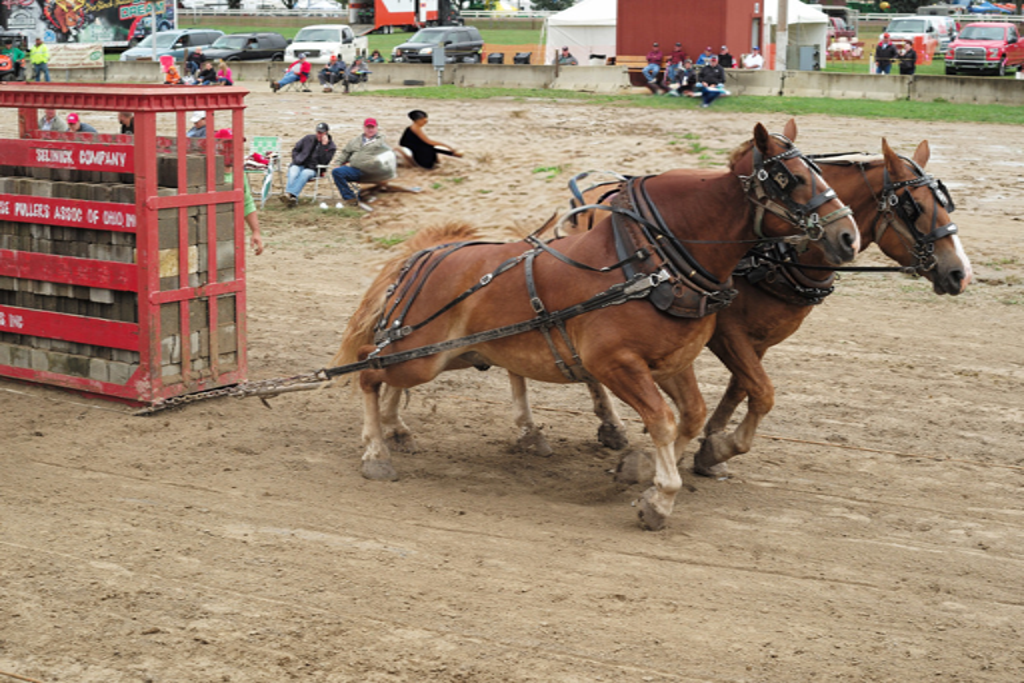

In [ ]:
res = inpaint(img, objs, ["людина 1", "людина", "людина 6", "людина 4", "людина 7", "людина 5"])
res.resize(img.shape[1::-1])

# Eval

In [ ]:
import os

In [ ]:
selected_log = {}

In [ ]:
test_dir = "/content/drive/MyDrive/test images"
images = os.listdir(test_dir)
ids = iter(range(len(images)))

In [ ]:
curr = images[next(ids)]
curr = os.path.join(test_dir, curr)

In [ ]:
img, objs = read_and_overlay(curr)

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/50 [00:00<?, ?it/s]

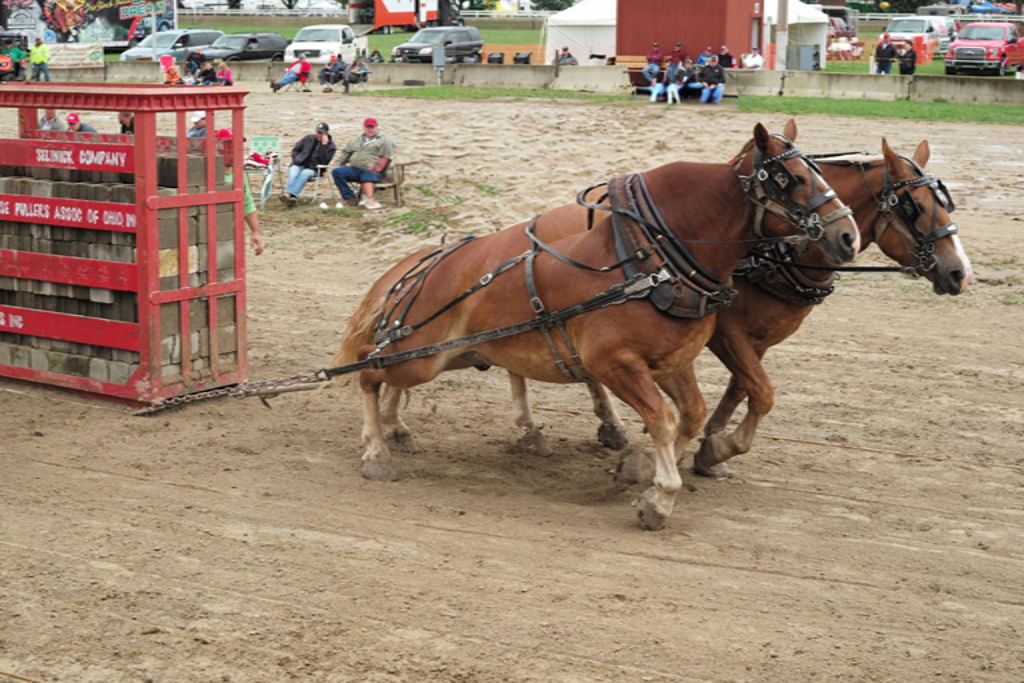

In [ ]:
selected = ["людина 1", "людина", "людина 6", "людина 4", "людина 7", "людина 5"]
res = inpaint(img, objs, selected)
res.resize(img.shape[1::-1])

In [ ]:
selected_log[curr] = selected

In [ ]:
with open("/content/drive/MyDrive/selected_log.json", "w") as f:
    json.dump(selected_log, f, indent=4)

In [ ]:
# with open("/content/drive/MyDrive/selected_log.json") as f:
#     d = json.load(f)